# Multi-Layer Perceptron Neural Network

Welcome to your third assignment. You will build a Multi-Layer Perceptron (MLP) neural network in this assignment. The goal of building such a model is to classify images of wearings.

## Exercises:
1. $\color{violet}{\textbf{(10\%) Data Preprocessing}}$
2. $\color{violet}{\textbf{(5\%) Parameter Initialization}}$
3. $\color{violet}{\textbf{(15\%) Linear Model and Activations}}$
4. $\color{violet}{\textbf{(5\%) Cross Entropy Loss}}$
5. $\color{violet}{\textbf{(30\%) Gradient Computation}}$
6. $\color{violet}{\textbf{(20\%) Gradient Descent Optimization}}$
7. $\color{violet}{\textbf{(15\%) Accuracy Evaluation}}$

## Instructions:
- Write your code only between the $\color{green}{\textbf{\small \#\#\# START CODE HERE \#\#\#}}$ and $\color{green}{\textbf{\small \#\#\# END CODE HERE \#\#\#}}$ commented lines. 
- $\color{red}{\textbf{Change code out of the designated area at your own risk.}}$
- Reference answers are provided after a certain coding blocks. Be aware if your answer is different from the reference..
- **Need to install [Torchvision](https://pytorch.org/vision/stable/index.html)**
    ```console
    pip install torchvision
    ```
**You will learn:**
- One-hot encoding for multi-class targets.
- Rectified Linear Unit (ReLU) activation function.
- Softmax activation.
- Forward and backward propagation of a generic MLP model.



## 1. Prepare Data
Torchvision provides a descent pool of datasets. We'll load one of the built-in dataset, [CIFAR10](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html) to investigate a multi-class classification problem.


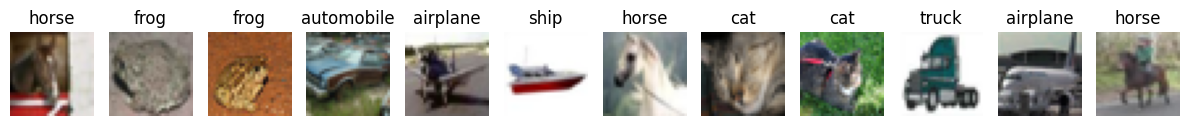

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms.v2 import Compose, ToImage, ToDtype
import numpy as np
import matplotlib.pyplot as plt

# Construct pre-processing pipeline
feature_transform_pipeline = Compose([
    ToImage(),
    ToDtype(torch.float32, scale=True),
    torch.flatten,
    torch.Tensor.numpy,
])
label_transform_pipeline = Compose([
    lambda x:torch.tensor([x]),
    lambda x:torch.nn.functional.one_hot(x,10),
    torch.squeeze,
    torch.Tensor.numpy,
])

# Download datasets
dataset_train = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=feature_transform_pipeline,
    target_transform = label_transform_pipeline,
)

dataset_val = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=feature_transform_pipeline,
)

# Create dataloaders
batch_size = 128
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)


# Visualize data samples
sample_batch_train = next(iter(dataloader_train))
fig, axs = plt.subplots(1, 12, figsize=(12, 4))
for i in range(12):
    sample_img = np.transpose(sample_batch_train[0][i].numpy().reshape(3, 32, 32), (1, 2, 0))  # reconstruct image to (H, W, C) format
    sample_cls = dataset_train.classes[sample_batch_train[1][i].numpy().argmax()]
    axs[i] = plt.subplot(1, 12, i + 1)
    axs[i].set_title(sample_cls)
    axs[i].axis('off')
    axs[i].imshow(sample_img)  # image is already in (H, W, C) format
plt.tight_layout()

## 2. Construct Multi-Layer Perceptron Model
A Multi-Layer Perceptron (MLP) model is featured with multiple layers of transformed features. Any two adjacent layer are connected by a linear model and an activation function. The linear model is governed by a set of weight parameters and a set of bias parameters. The general structure of an MLP model is shown below.


### 2.1. Initialize Parameters
A linear model governed by weights $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ transforms features, $\mathbf{X}^{[l-1]}$ to $\mathbf{Z}^{[l]}$.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

Where, $\mathbf{X}^{[l-1]}$ has $N_{l-1}$ features and $\mathbf{X}^{[l]}$ has $N_{l}$ features, $\mathbf{W}^{[l]}$ is with shape $(N_l, N_{l-1})$, $\mathbf{b}^{[l]}$ is with shape $(1, N_l)$


In order to get the MLP model prepared, we need to initialize weight matrix and bias vector in every layer.

### <font color=#582c83> Exercise 1: Parameters Initialization </font>
Define a function to initialize weights and biases parameters and save these parameters in a **dictionary**. 
- Input all the layers sizes (**include the input layer**) using a list or tuple.
- Use a **`for` loop** to randomly initialize $\mathbf{W}^{[l]}$ and $\mathbf{b}^{[l]}$ for transform the features from the $[l-1]$-th layer to the $[l]-th layer$.
- You may find [`np.random.normal()`](https://numpy.org/doc/2.0/reference/random/generated/numpy.random.normal.html) useful when you were trying to create arrays with random numbers.


In [4]:
def init_params(in_dims: int, hidden_dims: tuple, out_dims: int) -> dict:
    """
    Initialize the parameters of the MLP model.
    Args:
        in_dims: number of input dimensions.
        hidden_dims: tuple/list of hidden layer dimensions.
        out_dims: number of output dimensions.
    Returns:
        params: dictionary containing the initialized weights and biases.
    """
    layer_dims = (in_dims, *hidden_dims, out_dims)
    params = {}
    for l in range(len(layer_dims) - 1):
        params[f'W{l+1}'] = np.random.normal(loc=0, scale=0.1, size=(layer_dims[l + 1], layer_dims[l]))
        params[f'b{l+1}'] = np.random.normal(loc=0, scale=0.0001, size=(1, layer_dims[l + 1]))
    return params

# Example usage
np.random.seed(3321)  # for reproducibility
params_dummy = init_params(in_dims=sample_batch_train[0].numpy().shape[1], hidden_dims=(4, 3), out_dims=sample_batch_train[1].numpy().shape[1])
print(params_dummy)
for key in params_dummy:
    print(f"{key} shape: {params_dummy[key].shape}")


{'W1': array([[ 0.0368456 , -0.13878264, -0.0723142 , ...,  0.01476262,
        -0.10967347, -0.18631236],
       [ 0.0626109 , -0.11664279,  0.00737831, ..., -0.05391995,
        -0.00214825,  0.03616649],
       [-0.0892149 , -0.1090383 ,  0.00528383, ..., -0.10592102,
         0.15261464, -0.05313855],
       [ 0.11090477, -0.09542226,  0.22831787, ..., -0.11418551,
        -0.06934532, -0.22189655]], shape=(4, 3072)), 'b1': array([[ 1.04294659e-04, -5.35403148e-05,  1.14698968e-04,
         1.85000344e-04]]), 'W2': array([[-0.05080986,  0.1046614 ,  0.14066771,  0.00291042],
       [ 0.11845765, -0.04425832, -0.11718765, -0.03634791],
       [-0.09860422,  0.01093978, -0.07160529,  0.05205904]]), 'b2': array([[-1.30894305e-04, -8.39531783e-05, -9.25686401e-05]]), 'W3': array([[-0.15204258, -0.08445182,  0.1476833 ],
       [-0.07196692, -0.07523497, -0.03315568],
       [ 0.11689522,  0.111967  ,  0.02795843],
       [-0.02053044, -0.11351672,  0.04676231],
       [ 0.09881951,  0.

**Expected Output**:
>
```console
{'W1': array([[ 0.0368456 , -0.13878264, -0.0723142 , ...,  0.01476262,
        -0.10967347, -0.18631236],
       [ 0.0626109 , -0.11664279,  0.00737831, ..., -0.05391995,
        -0.00214825,  0.03616649],
       [-0.0892149 , -0.1090383 ,  0.00528383, ..., -0.10592102,
         0.15261464, -0.05313855],
       [ 0.11090477, -0.09542226,  0.22831787, ..., -0.11418551,
        -0.06934532, -0.22189655]], shape=(4, 3072)), 'b1': array([[ 1.04294659e-04, -5.35403148e-05,  1.14698968e-04,
         1.85000344e-04]]), 'W2': array([[-0.05080986,  0.1046614 ,  0.14066771,  0.00291042],
       [ 0.11845765, -0.04425832, -0.11718765, -0.03634791],
       [-0.09860422,  0.01093978, -0.07160529,  0.05205904]]), 'b2': array([[-1.30894305e-04, -8.39531783e-05, -9.25686401e-05]]), 'W3': array([[-0.15204258, -0.08445182,  0.1476833 ],
       [-0.07196692, -0.07523497, -0.03315568],
       [ 0.11689522,  0.111967  ,  0.02795843],
       [-0.02053044, -0.11351672,  0.04676231],
       [ 0.09881951,  0.06431384, -0.11860699],
       [ 0.00803933, -0.22014142,  0.12180135],
       [-0.13652621, -0.1537195 ,  0.06154869],
       [ 0.10395008,  0.03099951, -0.14420826],
       [ 0.09003759,  0.08182519, -0.0092451 ],
       [ 0.19018528,  0.03363918, -0.08740904]]), 'b3': array([[ 1.27958953e-04,  3.61149398e-05, -9.17852105e-05,
         1.05089716e-05,  2.14611004e-04,  4.75264495e-06,
        -2.10323449e-05, -5.12094207e-05, -4.22673712e-05,
         8.11998844e-05]])}
W1 shape: (4, 3072)
b1 shape: (1, 4)
W2 shape: (3, 4)
b2 shape: (1, 3)
W3 shape: (10, 3)
b3 shape: (1, 10)
```

### 2.2 - Activate Features

![mlp](./model.png)

A linear model transforms features, $\mathbf{X}^{[l-1]}$ to $\mathbf{Z}^{[l]}$. Then we apply a non-linear activation function on $\mathbf{Z}^{[l]}$ to form new features $\mathbf{Z}^{[l]}$ in the $l$-th layer.

$\mathbf{Z}^{[l]} = \mathbf{X}^{[l-1]} \cdot \mathbf{W}^{[l]T} + \mathbf{b}^{[l]}$

$\mathbf{X}^{[l]} = ReLU(\mathbf{Z}^{[l]}) = 
    \begin{cases}
        0   & z \leq 0 \\
        z   & z > 0
    \end{cases}
$

or,

$\mathbf{X}^{[l]} = \sigma (\mathbf{Z}^{[l]}) = \frac{1}{1 + e^{-\mathbf{Z}^{[l]}}}$

For a multi-class classification problem, it is common to activcate the last layer with a softmax function.

#### $$\hat{y}_i = \frac{e^{z^{[L]}_i}}{\sum^C_{i=1} e^{z^{[L]}_i}}$$

The maxtrix $\mathbf{Z}^{[L]}$ has shape: $(M, C)$, where $M$ is the number of samples, $C$ is the number of classes. When applying softmax activation, we only want to apply it on the 2nd dimension (axis) or perform it on each row in the $\mathbf{Z}^{[L]}$ matrix.

### <font color=#582c83> Exercise 2. Activations Functions and Derivatives </font>



In [5]:
### START CODE HERE ### (≈ 9 lines of code)
def sigmoid(z):
    """ Sigmoid function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return 1 / (1 + np.exp(-z))

def d_sigmoid(z):
    """ Derivative of sigmoid function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return sigmoid(z) * (1 - sigmoid(z))

def tanh(z):
    """ Hyperbolic Tangent function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

def d_tanh(z):
    """ Derivative of hyperbolic tangent function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return 1 - tanh(z) ** 2

def relu(z):
    """ ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.maximum(0, z)

def d_relu(z):
    """ Derivative of ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return (z > 0).astype(float)

def leaky_relu(z, a=0.05):
    """ Leaky ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
        a: constant, a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.maximum(a * z, z)

def d_leaky_relu(z, a=0.05):
    """ Derivative of Leaky ReLU function
    Args:
        z: independent variable, could be an arrary of any shape or a scalar. 
        a: constant, a scalar. 
    Returns:
        dependent variable, could be an arrary of any shape or a scalar. 
    """
    return np.where(z > 0, 1.0, a)

def softmax(z):
    """ Softmax function
    Args:
        z: independent variable, 2d array with shape (# samples, # features)
    Returns:
        probabilities: dependent variable, 2d array with shape (# samples, # features)
    """
    probabilities = np.exp(z) / np.sum(np.exp(z), axis=-1, keepdims=True)
    return probabilities

# Sanity check
z_dummy = np.linspace(-2, 2, 10).reshape(2, 5)
print(f"Input = \n{z_dummy}")
print(f"Sigmoid activation = \n{sigmoid(z_dummy)}")
print(f"Sigmoid derivative = \n{d_sigmoid(z_dummy)}")
print(f"Hyper Tangent activation = \n{tanh(z_dummy)}")
print(f"Hyper Tangent derivative = \n{d_tanh(z_dummy)}")
print(f"ReLU activation = \n{relu(z_dummy)}")
print(f"ReLU derivative = \n{d_relu(z_dummy)}")
print(f"Leaky ReLU activation = \n{leaky_relu(z_dummy, a=0.1)}")
print(f"Leaky ReLU derivative = \n{d_leaky_relu(z_dummy, a=0.1)}")
print(f"Softmax activation = \n{softmax(z_dummy)}")



Input = 
[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Sigmoid activation = 
[[0.11920292 0.17428532 0.2476638  0.33924363 0.44467194]
 [0.55532806 0.66075637 0.7523362  0.82571468 0.88079708]]
Sigmoid derivative = 
[[0.10499359 0.14390995 0.18632644 0.22415739 0.24693881]
 [0.24693881 0.22415739 0.18632644 0.14390995 0.10499359]]
Hyper Tangent activation = 
[[-0.96402758 -0.9146975  -0.8044548  -0.58278295 -0.21863508]
 [ 0.21863508  0.58278295  0.8044548   0.9146975   0.96402758]]
Hyper Tangent derivative = 
[[0.07065082 0.16332849 0.35285247 0.66036404 0.9521987 ]
 [0.9521987  0.66036404 0.35285247 0.16332849 0.07065082]]
ReLU activation = 
[[0.         0.         0.         0.         0.        ]
 [0.22222222 0.66666667 1.11111111 1.55555556 2.        ]]
ReLU derivative = 
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
Leaky ReLU activation = 
[[-0.2        -0.15555556 -0.11111111 -0.06666667 -0.02222222]
 [ 0.2

**Expected Output**:
>
```console
Input = 
[[-2.         -1.55555556 -1.11111111 -0.66666667 -0.22222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Sigmoid activation = 
[[0.11920292 0.17428532 0.2476638  0.33924363 0.44467194]
 [0.55532806 0.66075637 0.7523362  0.82571468 0.88079708]]
Sigmoid derivative = 
[[0.10499359 0.14390995 0.18632644 0.22415739 0.24693881]
 [0.24693881 0.22415739 0.18632644 0.14390995 0.10499359]]
Hyper Tangent activation = 
[[-0.96402758 -0.9146975  -0.8044548  -0.58278295 -0.21863508]
 [ 0.21863508  0.58278295  0.8044548   0.9146975   0.96402758]]
Hyper Tangent derivative = 
[[0.07065082 0.16332849 0.35285247 0.66036404 0.9521987 ]
 [0.9521987  0.66036404 0.35285247 0.16332849 0.07065082]]
ReLU activation = 
[[0.         0.         0.         0.         0.        ]
 [0.22222222 0.66666667 1.11111111 1.55555556 2.        ]]
ReLU derivative = 
[[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]]
Leaky ReLU activation = 
[[-0.2        -0.15555556 -0.11111111 -0.06666667 -0.02222222]
 [ 0.22222222  0.66666667  1.11111111  1.55555556  2.        ]]
Leaky ReLU derivative = 
[[0.1 0.1 0.1 0.1 0.1]
 [1.  1.  1.  1.  1. ]]
Softmax activation = 
[[0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]
 [0.06801606 0.10607944 0.16544399 0.25803034 0.40243017]]
```

### 2.3. Forward Propagation

In [11]:
def linear(in_features, weights, biases):
    """ Linear function
    Args:
        in_features: input feature matrix, 2d array with shape (# samples, # input features)
        weights: weight parameter matrix, 2d array with shape (# next layer features , # input features)
        biases: bias parameter vector, 2d array with shape (1, # next layer features)
    Returns:
        linear_output: linear model output feature matrix, 2d array with shape (# samples, # next layer features)
    """
    linear_output = in_features @ weights.T + biases
    return linear_output

def forward(in_features, params, hidden_activation=None, out_activation=None):
    """ Forward function
    Args:
        in_features: feature matrix, 2d array with shape (# samples, # pixels)
        params: a dictionary of weights and biases
            params = {
                'W_1': weight matrix of the first layer, 2d array with shape (# hidden features in 1st layer, # input features)
                'b_1': bias vector of the first layer, 2d array with shape (1, # hidden features in 1st layer)
                ...
                'W_L': weight matrix of the last layer, 2d array with shape (# hidden features in output layer, # hidden features in L-1 layer)
                'b_L': bias vector of the last layer, 2d array with shape (1, # output features)
            }
        hidden_activation: activation function for hidden layers, could be sigmoid, relu, etc. If None, no activation is applied.
        out_activation: activation function for output layer, could be sigmoid, softmax, etc. If None, no activation is applied.
    Returns:
        predictions: predicted probabilities, a column vector or 2d array with shape (# samples, # output features)
        cache: linear activated features
    """

    num_layers = len(params) // 2
    # Input layer
    cache = {'X0': in_features}
    # Hidden layers
    for i in range(num_layers - 1):
        cache[f'Z{i+1}'] = linear(cache[f'X{i}'], params[f'W{i+1}'], params[f'b{i+1}'])
        if hidden_activation=="relu":
            cache[f'X{i+1}'] = relu(cache[f'Z{i+1}'])
        elif hidden_activation=="leaky_relu":
            cache[f'X{i+1}'] = leaky_relu(cache[f'Z{i+1}'])
        elif hidden_activation=="sigmoid":
            cache[f'X{i+1}'] = sigmoid(cache[f'Z{i+1}'])
        elif hidden_activation=="tanh":
            cache[f'X{i+1}'] = tanh(cache[f'Z{i+1}'])
        else:
            cache[f'X{i+1}'] = cache[f'Z{i+1}']
    # Output layer
    cache[f'Z{num_layers}'] = linear(cache[f'X{num_layers-1}'], params[f'W{num_layers}'], params[f'b{num_layers}'])
    if out_activation=="relu":
        predictions = relu(cache[f'Z{num_layers}'])
    elif out_activation=="leaky_relu":
        predictions = leaky_relu(cache[f'Z{num_layers}'])
    elif out_activation=="sigmoid":
        predictions = sigmoid(cache[f'Z{num_layers}'])
    elif out_activation=="tanh":
        predictions = tanh(cache[f'Z{num_layers}'])
    elif out_activation=="softmax":
        predictions = softmax(cache[f'Z{num_layers}'])
    else:
        predictions = cache[f'Z{num_layers}']
    return predictions, cache

# Sanity check
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "sigmoid", "softmax")
print(f"Features: {list(cache_dummy.keys())[:]}")
print(f"Shape of dummy predictions: {preds_dummy.shape}")
print(f"Dummy prediction sample with sigmoid activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "tanh", "softmax")
print(f"Dummy prediction sample with hyperbolic tangent activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "relu", "softmax")
print(f"Dummy prediction sample with ReLU activations:\n{preds_dummy[0]}")
preds_dummy, cache_dummy = forward(sample_batch_train[0].numpy(), params_dummy, "leaky_relu", "softmax")
print(f"Dummy prediction sample with Leaky ReLU activations:\n{preds_dummy[0]}")


Features: ['X0', 'Z1', 'X1', 'Z2', 'X2', 'Z3']
Shape of dummy predictions: (128, 10)
Dummy prediction sample with sigmoid activations:
[0.09528843 0.09125905 0.11383818 0.09590308 0.1024395  0.09614213
 0.08904265 0.09979815 0.10857134 0.1077175 ]
Dummy prediction sample with hyperbolic tangent activations:
[0.10076069 0.09910421 0.09969189 0.10101848 0.09819445 0.10342691
 0.10052092 0.09823987 0.09928544 0.09975714]
Dummy prediction sample with ReLU activations:
[0.09428151 0.09640544 0.10352176 0.09853189 0.10229858 0.09985063
 0.09449275 0.10236338 0.10237048 0.10588358]
Dummy prediction sample with Leaky ReLU activations:
[0.09453645 0.09626262 0.1035647  0.09868714 0.10195887 0.10033994
 0.09460139 0.10198885 0.10230915 0.10575089]


## 3. Multi-Class Cross Entropy Loss
For multi-class classification problem, it is quite standard to use a general form of cross entropy function to evaluate model prediction vs. target. 
#### $\mathcal{L}(\mathbf{\hat{Y}}, \mathbf{Y}) = -\frac{1}{M} \sum_{m=1}^M \sum_{c=1}^C {^{(m)} y_c} \log {^{(m)} \hat{y}_c}$

### $\color{violet}{\textbf{(5\%) Exercise 4: Cross Entropy Loss}}$
Define a cross entropy function to compute the average loss between the prediction array and the groundtruth label array. 


In [ ]:
### START CODE HERE ### (≈ 1 line of code)
def ce_loss(predictions, labels):
    """ Cross entropy loss function
    Args:
        predictions (matrix): 2d array with shape (M, C)
        labels (matrix): 2d array with shape (M, C)
    Returns:
        loss: scalar, averaged ce loss
    """
    loss = None

    return loss
### END CODE HERE ###

# Sanity check
dummy_labels = np.zeros((8, 3))
dummy_labels[np.arange(8), np.random.randint(0, 3, (8,))] = 1
dummy_loss = ce_loss(dummy_preds, dummy_labels)
print(f"CE loss of dummy prediction: {dummy_loss}")

**Expected Output**:
>
```console
CE loss of dummy prediction: 1.098647202419345
```

## 4. Back-Propagation
In order to know how to update weights and biases, we need to compute the gradient of the loss. This requires compute gradient of loss w.r.t. the variables in the last layer first. Then compute gradient of loss w.r.t. the variables in the previous layer next. And so on, until the gradient of loss w.r.t. the first layer is computed. 

Due to the fact that the last layer is softmax activated, $\frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}}$ can be computed differently without explicitly solve for derivative of softmax function.
$$d\mathbf{Z}^{[L]} = \frac{\partial \mathcal{L}}{\partial \mathbf{Z}^{[L]}} = \mathbf{\hat{Y}} - \mathbf{Y} $$

Then, from last layer $L$ to first layer, we need to repeatedly computing the gradient of loss according to the chain rule. The computation of a general layer $[l]$ is as follows.
$$d\mathbf{W}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{W}^{[l]}}} = d\mathbf{Z}^{[l]T} \cdot \mathbf{X}^{[l-1]}$$
$$d\mathbf{b}^{[l]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{b}^{[l]}}} = mean(d\mathbf{Z}^{[l]}, axis=0, keepdims=True)$$
$$d\mathbf{X}^{[l-1]} = d\mathbf{Z}^{[l]} \frac{\partial \mathbf{Z}^{[l]}}{\partial{\mathbf{X}^{[l-1]}}} = d\mathbf{Z}^{[l]} \cdot \mathbf{W}^{[l]}$$
$$d\mathbf{Z}^{[l-1]} = d\mathbf{X}^{[l-1]} * relu'(\mathbf{Z}^{[l-1]})$$


### $\color{violet}{\textbf{(30\%) Exercise 5: Gradient Computation}}$
- Define the derivative of sigmoid function.
- Define derivative of ReLU function.
- Define a function to perform backward propagation to compute gradient of the (cross entropy) loss

In [ ]:
### START CODE HERE ### (≈ 9 lines of code)
def d_sigmoid(x):
    """ Derivative of sigmoid function
    Args:
        x: scalar/array
    Returns:
        dydx: scalar/array, 0 if x < 0, 1 if x >= 0
    """
    dydx = None

    return dydx

def d_relu(x):
    """ Derivative of ReLU function
    Args:
        x: scalar/array
    Returns:
        dydx: scalar/array, 0 if x < 0, 1 if x >= 0
    """
    dydx = None
    dydx[x < 0] = None

    return dydx

def grad(predictions, labels, params, cache, activation='relu'):
    """ Backward propogating gradient computation
    Args:
        predictions (matrix): 2d array with shape (M, C)
        labels (matrix): 2d array with shape (M, C)
        params: dictionary, stores W's and b's.
        cache: dictionary, stores intemediate X's and Z's.
        activation: string, type of the intermediate activation function.
    Returns:
        grads -- dictionary, stores gradient of the CE loss: dW's and db's
    """
    num_layers = int(len(params) / 2)
    grads = None  # dZ^[L]
    for i in reversed(range(num_layers)):
        grads['dW'+ str(i+1)] = None
        grads['db' + str(i+1)] = None
        if i==0:
            break  
        grads['dX' + str(i)] = None
        if activation == 'relu':
            grads['dZ' + str(i)] = None
        elif activation == 'sigmoid':
            grads['dZ' + str(i)] = None
        else:
            grads['dZ' + str(i)] = grads['dX' + str(i)]

    return grads
### END CODE HERE ###

# Sanity check
dummy_grads = grad(dummy_preds, dummy_labels, dummy_params, dummy_cache)
print(dummy_grads.keys())
print(dummy_grads)

**Expected Output**:
>
```console
dict_keys(['dZ3', 'dW3', 'db3', 'dX2', 'dZ2', 'dW2', 'db2', 'dX1', 'dZ1', 'dW1', 'db1'])
{'dZ3': array([[ 0.33339668, -0.66668347,  0.33328679],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668,  0.33331653, -0.66671321],
       [ 0.33339668, -0.66668347,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321],
       [-0.66660332,  0.33331653,  0.33328679],
       [ 0.33339668,  0.33331653, -0.66671321]]), 'dW3': array([[ 7.79094514e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 7.77672619e-05,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.55676713e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]]), 'db3': array([[ 0.08339668,  0.08331653, -0.16671321]]), 'dX2': array([[ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-6.06445677e-05,  1.51249634e-05, -1.23325920e-04,
         1.98449678e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
       [ 1.13883818e-04, -3.29905699e-05,  4.66135899e-05,
         3.31572328e-05],
       [-5.32294163e-05,  1.78635631e-05,  7.67488316e-05,
        -5.30117015e-05],
...
         7.64898491e-10, -2.25124333e-09, -1.93588520e-09],
       [-1.56762876e-09, -3.74956163e-09, -1.11294146e-09,
         8.11358070e-11, -4.79680573e-10,  6.84456641e-11]]), 'db1': array([[-1.36634221e-09,  9.72490113e-10,  4.98906290e-10,
         2.72315047e-10,  3.86057435e-10]])}
```

## 5. Optimization
We have been able to compute the gradient of the cross entropy loss. Now, it's time to perform gradient descent optimization to bring the loss down.

![](./gradient_dscent.png)


### $\color{violet}{\textbf{(20\%) Exercise 6: Gradient Descent Optimization}}$
Train your model. Bring both training loss and test loss down. **Note: you may need to spend more time on this task. So, get started as early as possible.**
1. Customize layer sizes.
2. Use previously created function to complete the training process.
3. Set appropriate iterations and learning rate
4. You can use a `for` loop to update weights and biases embedded in the `params` dictionary.
> Choose the activation function wisely. A poorly activated layer may cause longer training duration as well as poorer model performance.
#### $\color{red}{\text{Bring the \textbf{test} loss down below 0.5}}$


In [ ]:
### START CODE HERE ### (≈ 10 lines of code)
layer_sizes = None
params = None
num_iters = None
learning_rate = None
losses_train, losses_test = [], []
# Optimization loop
for i in range(num_iters):
    preds_train, cache = None
    preds_test, _ = None
    loss_train = None
    loss_test = None
    print(f"Iteration {i+1} training loss: {loss_train}, test loss: {loss_test}")
    losses_train.append(loss_train)
    losses_test.append(loss_test)
    grads = None
    for j in range(len(layer_sizes) -1):
        params['W'+str(j+1)] = None
        params['b'+str(j+1)] = None
### END CODE HERE ###

plt.plot(range(num_iters), losses_train, 'b--', range(num_iters), losses_test, 'r')


## 6. Evaluation
Besides cross entropy loss, classification accuracy is another key criteria to evaluate the model.
### $\color{violet}{\textbf{(15\%) Exercise 7: Accuracy Evaluation}}$
- Use [`np.argmax()`](https://numpy.org/doc/2.0/reference/generated/numpy.argmax.html#numpy-argmax) function to find out the index of the biggest number on a specified dimension (axis).
- $\textit{Accuracy} = \frac{\textit{Number of correct predictions}}{\textit{Total number of samples}}$

#### $\color{red}{\text{The \textbf{test} accuracy is expected to be greater than 0.8}}$


In [ ]:
### START CODE HERE ### (≈ 8 lines of code)
# Evaluate with train
pred_classes_train = None  # Get indices of max values in Yhat_train row-wise
is_correct_train = None  # Find out which predictions are correct
num_correct_train = None  # Calculate how many correct predictions are made
accuracy_train = None  # Calculate accuracy rate: correct # / total #
# Evaluate with test
pred_classes_test = None  # # Get indices of max values in Yhat_test row-wise
is_correct_test = None  # Find out which predictions are correct
num_correct_test = None  # Calculate how many correct predictions are made
accuracy_test = None  # Calculate accuracy rate: correct # / total #
### END CODE HERE ###

print(f"prediction accuracy on train set: {accuracy_train}")
print(f"prediction accuracy on test set: {accuracy_test}")

# Compare prediction and target
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = np.random.randint(0, len(test_set))
    img, label_true = test_set[sample_idx]
    label_pred = pred_classes_test[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"true: {category_keys[label_true]}, pred: {category_keys[label_pred]}")
    plt.axis("off")
    plt.imshow(img, cmap="gray")


## Congrats on finishing this assignment! 